# NIMMS Helium Synchrotron - XSuite Extraction Notebook
Author - R.  Taylor - taylor.r@cern.ch

With help from E. Benedetto, S. Detsi, C. Carollo

In [320]:
import psutil
import os
import gc
from memory_profiler import profile

# Function to clear memory
def clear_memory():
    process = psutil.Process(os.getpid())
    mem_info = process.memory_info()
    
    print("Before memory release:", mem_info.rss)
    
    gc.collect()  # Collect unreferenced objects
    
    mem_info = process.memory_info()
    print("After memory release:", mem_info.rss)

# Call the function to clear memory
clear_memory()


Before memory release: 19481559040
After memory release: 19481559040


In [322]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize as Norm
import matplotlib as mpl

from scipy import constants
from scipy.constants import m_p, e, c

import xtrack as xt
import xpart as xp
import xobjects as xo


from tqdm.notebook import tqdm                                                                 # Loading bars
from numpy.lib.format import open_memmap

# Consistent figure font sizes
plt.rcParams.update({'font.size': 14, 'axes.labelsize': 16, 'axes.titlesize': 18})

In [323]:
#os.chdir('/kaggle')

from shutil import copyfile
path_input="/kaggle/input/xhesync-extraction"
# copy our file into the working directory (make sure it has .py suffix)
copyfile(src=path_input+"/xtraction_helpers.py", dst="/kaggle/working/xtraction_helpers.py")

from xtraction_helpers import qse_tune, plot_two_twiss, make_beam_dist, SeptumSimple, BetatronCore   # Custom functions

#### Importing lattice from xsuite json instead of via cypmad

In [324]:
line = xt.Line.from_json(path_input+'/HeliumSynchrotron_Thick_S-1.json')

Done loading line from dict.           


In [325]:
nparticles, nturns = 10, 0.5*1E6
particles_per_turn = nparticles / nturns

In [326]:
# Xsuite Context #############
CPU = xo.ContextCpu()        #
GPU = xo.ContextCupy()       #
ctx = CPU                    #
##############################

In [327]:
# Details on the beam

T = 250*1E6         #Kinetic Energy eV
c = constants.c     # m/s, speed of light
E0 = 0.93827e9      # eV, proton rest energy
E = T + E0          # Total Energy

gamma = E / E0      # Normalized energy (lorentz)
beta = np.sqrt(1-gamma**-2) # normalised velocity (lorentz)
cp = np.sqrt(E**2 - E0**2)  # eV, particle momentum

circum = 32.99026403552847
# Revolution frequency
rev_freq = (constants.c * beta) / circum
turn_duration=circum/(constants.c * beta)
print(90*1E-6*rev_freq)

501.8443865525511


In [328]:
line.build_tracker()
#Twiss
particles = xp.Particles(mass0=xp.PROTON_MASS_EV, q0=1, p0c=cp, nparticles=nparticles)
line.particle_ref = particles
line.twiss_default['group_compound_elements'] = True
xtwiss = line.twiss(method='4d')

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [329]:
line.discard_tracker()

### Septa Modelling

In [330]:
# Defining aperture limits of the septa
ESAno = -55E-3

# Defining element type
electrostatic_septum = SeptumSimple(ESAno, loss=True)
Eseptum = xt.BeamInteraction(length=0, interaction_process=electrostatic_septum)
# Place in ring
line.insert_element(element=Eseptum, name='eseptum', at_s=0)

## Extraction Methods

In [331]:
method = 'rfko'
excite_at_s = 10.87175467850949

### Betatron Core

In [332]:
tune_init, tune_final = 2.654980777, 2.68
chroma = -6.596643555045744
dP = ((tune_final - tune_init)/chroma) /nturns
dP = 0

betatron_core = BetatronCore(1, dP)
Betatron = xt.BeamInteraction(length=betatron_core.length, interaction_process=betatron_core)

if method == 'betatron':
    line.insert_element(element=Betatron, name='betatron', at_s=excite_at_s)

Definition of the 3 monitora for tracking

In [333]:
#first monitor (on the sextupole)
monitor_sxt = xt.ParticlesMonitor(start_at_turn=0, stop_at_turn=nturns, num_particles=nparticles)
line.insert_element(element=monitor_sxt, name='msxt', at_s=9.87175)

#second monitor (symmetrical)
monitor_nd = xt.ParticlesMonitor(start_at_turn=0, stop_at_turn=nturns, num_particles=nparticles)
line.insert_element(element=monitor_nd, name='mnd', at_s=20.868504)

#third monitor (symmetrical)
monitor_rd = xt.ParticlesMonitor(start_at_turn=0, stop_at_turn=nturns, num_particles=nparticles)
line.insert_element(element=monitor_rd, name='mrd', at_s=31.765259)

### RF-KO

In [334]:
import random
from math import pi


In [335]:
def maxkick(KE, beam, V, a, L):
    'Equation calculating necessary angular kick for given particle'
    if beam == 'Carbon':
        Z, A = 6, 12
    if beam == 'Proton':
        Z, A = 1, 1
    m = 0.93827E3 * A #mass [MeV]
    E = A*KE + m
    p = np.sqrt(E**2 - m**2)
    beta = p/E

    theta = Z/A  * e/m_p * V/a * L/(beta**2 * c**2)
    return(theta)


In [336]:
#import os
#os.remove("Values.txt") 

In [ ]:
import numpy as np
from math import log

class RFKOFeedback():
    
    def __init__(self, nturns, step=500, setpoint = 0.01, limit0 = 1E-7):

        self.setpoint = setpoint
        self.nturns = nturns
        self.step = step
        
        self.limit = limit0                                                  
        self.loss_step_arr=np.zeros(step)
        self.total_loss=0
        self.error = 0
        self.kick=0
        self.dpdt=0
        
        self.last = False
        self.I = 0

    def solution(self,number):
        if (number>0):
            return 1
        elif (number <0) :
            return -1
        else:
            return 0
        
    def interact(self, particles): 
            
###########################################################################################################
## Amplitude Modulation
# Choose how the amplitude is going to be modulated:
# 1: Stable Amplitude = max_limit
# 2: Stable Amplitude with a pulse 
# 3: PI - controller 
###########################################################################################################
            
            AM=3

            nparticles = len(particles.state)
            current_turn = max(particles.at_turn[particles.state > 0])

            ## In case almost all the particle are extracted there is no reason to continue extraction
            if  len(particles.at_turn[particles.state < 0])>=nparticles-5:
                return         
            
            #if self.num_of_part==[]:
            #    self.num_of_part.append(nparticles)

            #total_loss=self.total_loss
            previous_loss=len(particles.at_turn[particles.state == -2]==max(1,current_turn-1))
            limit=self.limit
            step=self.step

            max_limit=10
            min_limit=1E-7

            if  len(particles.at_turn[particles.state < 0])==nparticles :
                return
            
###########################################################################################################
            if AM==1:
                if current_turn==0:
                    self.limit=max_limit

                new_limit=self.limit
                #self.limit.append(new_limit)
                kick=self.calc_kick(current_turn)    
                #self.kick=kick   
                if current_turn==0:
                    with open('/kaggle/working/Values.txt', 'w') as f:
                        f.write("Limit="+str(self.limit)+", Step="+str(step)+ "\n")
                        f.write("Turn \t Limit \t Kick \t Error \n")
                    f.close()
###########################################################################################################
            elif AM==2:
                lim=int(self.nturns/7)
                if current_turn <= 1.3*nturns/8 and current_turn >=nturns/8:
                    new_limit=max_limit
                elif current_turn >= 1.3*nturns/8:
                    new_limit=(self.limit+max_limit)/2
                else:
                    new_limit=self.limit
                #self.limit.append(new_limit)
                if current_turn <= nturns:
                    kick=self.calc_kick(current_turn)    
                    #self.kick=kick   
                    if current_turn==0:
                        with open('/kaggle/working/Values.txt', 'w') as f:
                            f.write("Limit="+str(self.limit)+"Lim="+str(lim)+", Step="+str(step)+ "\n")
                            f.write("Turn \t Limit \t Kick \t Error \n")
                        f.close()
###########################################################################################################
            elif AM==3:
                
                # initialize parameters
                previous_error = self.error
                previous_limit =self.limit
                setpoint=self.setpoint
                dparticles_dt=0
                new_limit=self.limit
                kick=self.kick
                
                ## define pid parameters
                Kp=0.5*1E-7*step/self.nturns
                Ki=1.8*Kp
                Kd=0#0.001*(max_limit)/nturns
                P=0
                I=0
                            
                previous_loss = sum((particle_df.state == -2)*( particle_df.at_turn == current_turn-1))              
                total_loss_old = self.total_loss+previous_loss
                self.total_loss=total_loss_old
                #loss_one_step_before=sum( ( particle_df.state == -2 )*( particle_df.at_turn < max(0,current_turn-step+1) ) )
                
                ## In the first turn create the txt file to store simulation data
                if current_turn==0:                  
                    print(setpoint)
                    with open('/kaggle/working/Values.txt', 'w') as f:
                        f.write('Kp='+str(Kp)+', Ki='+str(Ki)+", Limit0="+str(self.limit)+", setpoint="+str(setpoint)+", Step="+str(step)+ ", Min Limit="+str(min_limit)+ ", Max Limit="+str(max_limit)+"\n")
                        f.write("Turn \t Limit \t Kick \t Error \t Loss \t dparticles_dt \n")
                    f.close()
                    ## In case our simulation have already run all the nturns or almost all the particles are extracted close the .txt file and print that our extraction is over
                    """
                    elif current_turn==nturns:
                        if self.last==False:
                            print("End of simulation")
                            f=open('/kaggle/working/Values.txt', 'a') 
                            f.write("Total Loss = "+str(total_loss_old) + " out of "+ str(nparticles)+" particles" )
                            f.close
                            self.last=True
                        return
                    """
                elif  len(particles.at_turn[particles.state < 0])>=nparticles-5 :
                    if self.last==False:
                        print("All the particles are lost")
                        f=open('/kaggle/working/Values.txt', 'a') 
                        f.write("Total Loss = "+str(total_loss_old) + " out of "+ str(nparticles)+" particles" )
                        f.close()
                        self.last=True
                    return
                elif self.last==True:
                    return
                
                self.loss_step_arr[int(current_turn%step)]=previous_loss
                
                loss_one_step_before=sum(self.loss_step_arr)
                dparticles_dt=(loss_one_step_before)/step

                self.error=setpoint-dparticles_dt
                error=self.error
                            
                ## print all the calculated values on a txt file
                path_to_values='/kaggle/working/Values.txt'
                f=open(path_to_values, 'a') 
                #pi=P+I
                f.write(str(current_turn-1)+"\t"+str(new_limit)+"\t"+str(kick)+"\t"+str(self.error)+'\t'+str(previous_loss)+'\t'+str(dparticles_dt)+"\n")

                ## After one step turns update the kick's limit in every step using a pid controller               
                if current_turn % step == 0 and current_turn > 0:

                    P = Kp*error
                    I = self.I + Ki*error*step
                    D =Kd*(self.error - previous_error)/step 
                    pi=P+I
                    print(current_turn, ", total loss:",total_loss_old, ", lost one step before: ",loss_one_step_before,", dp/dt:",dparticles_dt,", PI:",pi)
                    new_limit = max(previous_limit +P + I + D,min_limit)*(len(particles.at_turn[particles.state < 0])>nparticles/2)+(previous_limit +P + I + D)*(len(particles.at_turn[particles.state < 0])<=nparticles/2)
                    new_limit=self.solution(new_limit)*(min(abs(new_limit),max_limit))
                    self.limit=new_limit
                    self.I=I

                ## In case we have extraction in last turn, print the parameters
                if previous_loss!=0 and current_turn!=0:
                    print("turn=", current_turn-1,", limit(1E4)=",new_limit*1E4,", kick(1E4)=",kick*(1E4),", current loss=",previous_loss,", total loss=", total_loss_old, ', loss one step before',loss_one_step_before)

                        
                kick=self.calc_kick(current_turn)    
                self.kick=kick

            ## Aplying the kick
            particles.px += (particles.state > 0) * kick     # Adds a kick of theta to the active particles

        
###########################################################################################################
## Frequency Modulation
###########################################################################################################
    def calc_kick(self,current_turn,FM=6):

        # Use FM variable to choose how Frequency will be modulated:
        # 1. Random points between the limits  (~ Guilia's approch)
        # 2. Standar Frequency Qx
        # 3. Frequency Qx + A small random noise 
        # 4. Frequency is choose with np.random.normal function from a certain bandwidth  (~ Taylor's approch)
        # 5. Frequency is changing linearly into a certain bandwidth (~ Thomas' approch)
        
        curr_kick=0
        A=self.limit

        if FM== 1:                                                              # Random
            sign=random.randint(0,1)
            curr_kick=A*(sign*np.random.uniform(0,1)-(1-sign)*np.random.uniform(0,1))
        elif FM == 2:           # 3rd Resonance
            Qx=3-xtwiss.qx
            time  = np.arange(0, 1/(Qx), 0.05)
            t = current_turn % len(time)
            curr_kick=A*np.sin(2*pi*Qx*time[t])
        elif FM == 3:                                                           # 3rd Resonance with noise
            Qx=3-xtwiss.qx
            time  = np.arange(0, 1/(Qx), 0.05)
            t = current_turn % len(time)
            curr_kick=A*(np.sin(2*pi*Qx*time[t])+0.2*np.random.uniform(0,1))
        elif FM == 4:                                                           # Gaussian Frequency
            # Bandwidth 
            left_limit=0.33933770
            right_limit=0.3513819
            # Take frequencys from the bandwidth with a gaussian probabillity
            Q=np.random.normal(left_limit,right_limit)       
            time  = np.arange(0, 1/Q, 0.05)
            t = current_turn % len(time)
            curr_kick=A*np.sin(2*pi*Q*time[t])
        elif FM == 5:                                                           # Linerly Changing Frequency
            # Bandwidth 
            left_limit=0.33933770
            right_limit=0.3513819

            carrier_frequency =  2*pi*(3-xtwiss.qx)  
            modulator_frequency = carrier_frequency/4
            modulation_index = 1.0

            time  = np.arange(0, 1/(modulator_frequency), 0.05);
            modulator = np.sin( modulator_frequency * time) * modulation_index
            carrier = np.sin(carrier_frequency * time)
            product = np.zeros_like(modulator)

            modulator = np.sin(modulator_frequency * time) * modulation_index
            carrier = np.sin(carrier_frequency * time)
            product = np.zeros_like(modulator)

            t = current_turn % len(time)
            product = A*np.sin((carrier_frequency* time[t] + modulator[t] ))
            #print("t=",t,product)

            # Take frequencys from the bandwidth linearly
            sign=random.randint(-1,1)
            curr_kick=product
            
        elif  FM == 6:
            
            chirp_period=300
            t = current_turn % chirp_period

            start_freq = 0.33933770  # Hz
            end_freq = 0.3513819   # Hz
            
            freq = 2 * np.pi * (start_freq + (end_freq - start_freq) * t / chirp_period )
            curr_kick=A*np.sin(freq*t)
            
        return curr_kick
    
    

In [338]:
# Defining element type
rfko_exciter = RFKOFeedback(nturns)
RFKO = xt.BeamInteraction(length=0, interaction_process=rfko_exciter)
# Place in ring
line.insert_element(element=RFKO, name='rfko', at_s=0)


## Beam Generation

In [339]:
line.build_tracker()
particles = xp.Particles(mass0=xp.PROTON_MASS_EV, q0=1, p0c=cp, nparticles=nparticles)
line.particle_ref = particles
line.twiss_default['group_compound_elements'] = True
xtwiss = line.twiss(method='4d')

# Using the Twiss optics at starting point to generate beam
#Params = xtwiss[:, 'ese_mk']
# Emittance
#Params.ex, Params.ey = 1E-7, 1E-7 # 4.1e-7, 4.1e-7
# Momentum spread
#Params.dpp = 1E-3

#Beam = make_beam_dist(Params, nparticles, mom_dist=True)

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
The line has collective elements.
In the twiss computation collective elements are replaced by drifts
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [340]:
import pandas as pd
particles_csv = pd.read_csv(r'/kaggle/input/xhesync-extraction/InitialDistribution_dpp0_S_1_np2000.csv')
print(particles_csv)
particle_df = particles.from_pandas(particles_csv)

      Unnamed: 0  start_tracking_at_element   q0         mass0    s      zeta  \
0              0                         -1  1.0  9.382721e+08  0.0 -3.259213   
1              1                         -1  1.0  9.382721e+08  0.0 -0.483784   
2              2                         -1  1.0  9.382721e+08  0.0 -0.525183   
3              3                         -1  1.0  9.382721e+08  0.0 -1.966580   
4              4                         -1  1.0  9.382721e+08  0.0 -8.576912   
...          ...                        ...  ...           ...  ...       ...   
1888        1888                         -1  1.0  9.382721e+08  0.0 -0.070856   
1889        1889                         -1  1.0  9.382721e+08  0.0 -1.568613   
1890        1890                         -1  1.0  9.382721e+08  0.0 -1.820734   
1891        1891                         -1  1.0  9.382721e+08  0.0 -0.925279   
1892        1892                         -1  1.0  9.382721e+08  0.0 -2.045291   

      chi  charge_ratio  we

In [341]:
print(len(particle_df.at_turn[particle_df.state > 1]))
print(particle_df.at_turn)

print(sum(particle_df.state==-1 ))

aaa = particle_df.state == 1
bbb = particle_df.at_turn > 1
print(aaa,"\n",bbb)
print(sum(aaa*bbb))

#p = particle_df.filter(aaa * bbb)
#print(len(p.x))
#aaa.shape, bbb.shape, particle_df.x.shape

0
[10000 10000 10000 ... 10000 10000 10000]
0
[ True  True  True ...  True  True  True] 
 [ True  True  True ...  True  True  True]
1893


In [342]:
particle_df.at_turn = np.zeros_like(particle_df.at_turn)


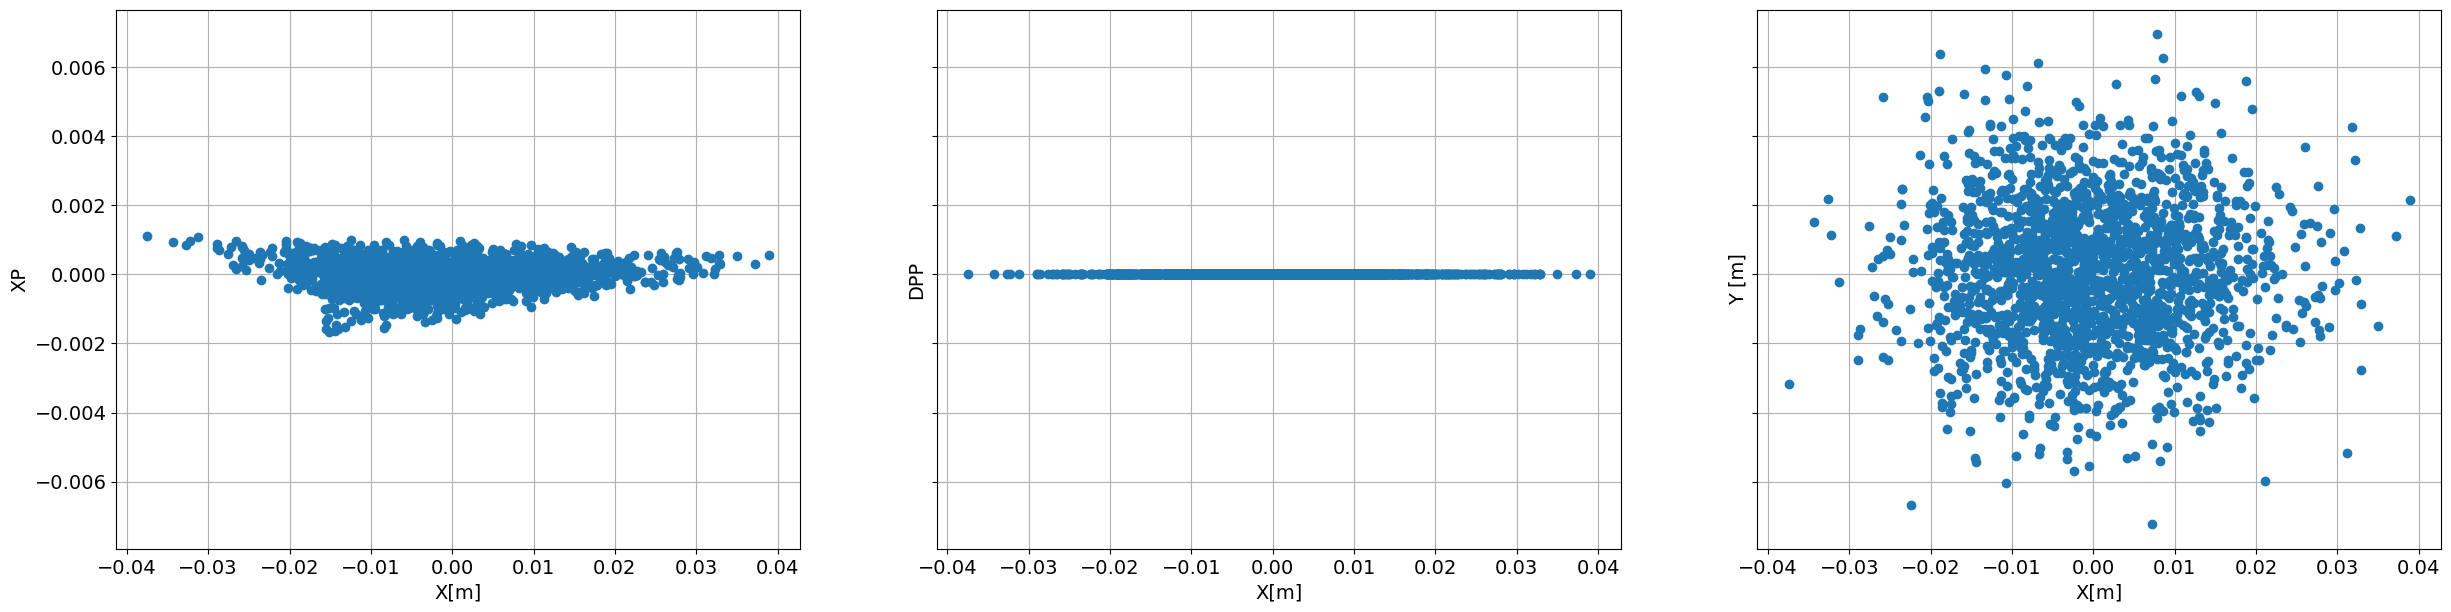

In [343]:
#particles = line.build_particles(x=Beam[0], px=Beam[1], y=Beam[2], py=Beam[3], delta=Beam[5], nparticles=nparticles)
#print(particles)

plt.rcParams.update({'font.size': 14, 'axes.labelsize': 14, 'axes.titlesize': 14})
figure, [ax1,ax2,ax3] = plt.subplots(nrows=1, ncols=3,figsize=(30, 7),sharey=True)

ax1.plot(particle_df.x, particle_df.px,'o')
ax1.set_ylabel('XP')

ax2.plot(particle_df.x, particle_df.delta,'o')
ax2.set_ylabel('DPP')

ax3.plot(particle_df.x, particle_df.y,'o')
ax3.set_ylabel('Y [m]')

for ax in ([ax1,ax2,ax3] ):
    ax.set_xlabel("X[m]")
    ax.grid()

## Tracking

In [344]:
len(particle_df.state)
loss0=particle_df.at_turn[np.where(particle_df.state == -2)]


In [345]:
for iturn in range(int(nturns)):
    line.track(particle_df)

0.01
500 , total loss: 0 , lost one step before:  0.0 , dp/dt: 0.0 , PI: 4.505e-10
turn= 506 , limit(1E4)= 0.001004505 , kick(1E4)= -0.0006268687912562106 , current loss= 1 , total loss= 1 , loss one step before 1.0
turn= 723 , limit(1E4)= 0.001004505 , kick(1E4)= 0.0008275070864503841 , current loss= 1 , total loss= 2 , loss one step before 2.0
1000 , total loss: 2 , lost one step before:  2.0 , dp/dt: 0.004 , PI: 7.203e-10
1500 , total loss: 2 , lost one step before:  0.0 , dp/dt: 0.0 , PI: 1.1704999999999998e-09
2000 , total loss: 2 , lost one step before:  0.0 , dp/dt: 0.0 , PI: 1.6204999999999997e-09
2500 , total loss: 2 , lost one step before:  0.0 , dp/dt: 0.0 , PI: 2.0705e-09
3000 , total loss: 2 , lost one step before:  0.0 , dp/dt: 0.0 , PI: 2.5204999999999997e-09
3500 , total loss: 2 , lost one step before:  0.0 , dp/dt: 0.0 , PI: 2.9704999999999996e-09
4000 , total loss: 2 , lost one step before:  0.0 , dp/dt: 0.0 , PI: 3.4204999999999995e-09
4500 , total loss: 2 , lost one

KeyboardInterrupt: 

In [346]:
import json

with open("particles_save_monitor_sxt.json", 'w') as fid:
    json.dump(monitor_sxt.data.to_dict(), fid, cls=xo.JEncoder)
with open("particles_save_monitor_nd.json", 'w') as fid:
    json.dump(monitor_nd.data.to_dict(), fid, cls=xo.JEncoder)
with open("particles_save_monitor_rd.json", 'w') as fid:
    json.dump(monitor_rd.data.to_dict(), fid, cls=xo.JEncoder)

## Plotting

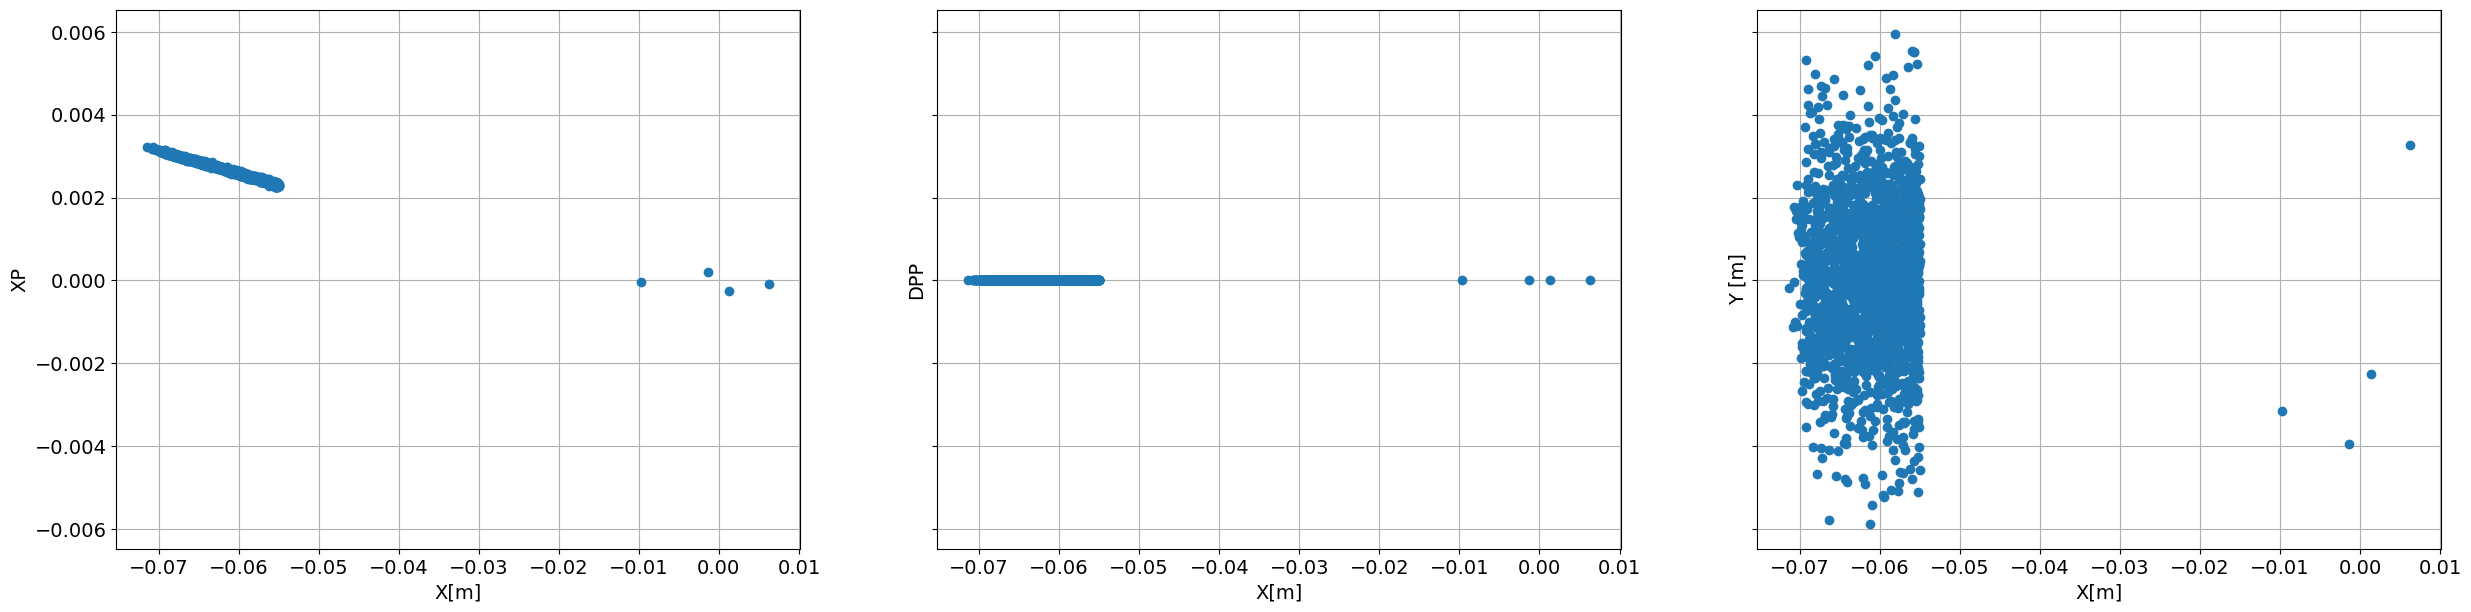

In [347]:
plt.rcParams.update({'font.size': 14, 'axes.labelsize': 14, 'axes.titlesize': 14})
figure, [ax1,ax2,ax3] = plt.subplots(nrows=1, ncols=3,figsize=(30, 7),sharey=True)

ax1.plot(particle_df.x, particle_df.px,'o')
ax1.set_ylabel('XP')

ax2.plot(particle_df.x, particle_df.delta,'o')
ax2.set_ylabel('DPP')

ax3.plot(particle_df.x, particle_df.y,'o')
ax3.set_ylabel('Y [m]')

for ax in ([ax1,ax2,ax3] ):
    ax.set_xlabel("X[m]")
    ax.grid()

In [348]:
import numpy as np
import matplotlib.pyplot as plt
import os 
#os.chdir('XHeSync_Extraction')

In [349]:
Values = open('/kaggle/working/Values.txt', 'r')
Lines = Values.readlines()
print(Lines[0])
line0=Lines[0].split(", ")
for i in range(0,len(line0)):
    print(line0[i])
#Kp= (line0[0].split("=")[1])
#Limit0=(line0[1].split("=")[1])
#Lim=int(float(line0[2].split("=")[1]))
#Step=(line0[3].split("=")[1])
Min_Limit=(line0[5].split("=")[1])
Max_Limit=(line0[6].split("=")[1])
setpoint=float(line0[3].split("=")[1])
print(setpoint)

Kp=4.9999999999999995e-11, Ki=9e-11, Limit0=1e-07, setpoint=0.01, Step=500, Min Limit=1e-07, Max Limit=10

Kp=4.9999999999999995e-11
Ki=9e-11
Limit0=1e-07
setpoint=0.01
Step=500
Min Limit=1e-07
Max Limit=10

0.01


In [350]:
last_line=Lines[-1]
print(Lines[-1])

#last_line=last_line.split("Total Loss = ")
#last_line[1]=last_line[1].split(" out of ")
#extr_particles=last_line[1][0]
#numparticles=last_line[1][1]


264077	1.6047175299999977e-05	1.1900395788466685e-05	0.008	0	0.002



In [351]:
Lines[-1]

'264077\t1.6047175299999977e-05\t1.1900395788466685e-05\t0.008\t0\t0.002\n'

In [352]:
#Lines.pop()
#print(Lines[:])
turn=[]
limit=[]
kick=[]
error=[]
loss=[]
dpdt=[]

print(Lines[-1])
if len(Lines)>1:
    for line in Lines[2:len(Lines)-2]:
        #print(line)
        line=line.split('\t')
        line_array=np.array(line) 
        # print(np.array(line))
        turn.append( float(line_array[0]))
        limit.append(float(line_array[1]))
        kick.append( float(line_array[2]))
        error.append(float(line_array[3]))
        loss.append(float(line_array[4]))
        dpdt.append(float(line_array[5]))


264077	1.6047175299999977e-05	1.1900395788466685e-05	0.008	0	0.002



In [359]:
nturns=len(turn)
particles_per_turn=np.zeros(nturns)
extr_particles_per_turn=np.zeros(nturns)
extr_particles=particle_df.at_turn[np.where(particle_df.state < 0)]

print(len(particle_df.at_turn[np.where(particle_df.state < 0)]))

for i in range(0,len(extr_particles)):
    j=extr_particles[i]
    #print(j)
    if j>1E4:
        particles_per_turn[j-nturns]+=1
    else:
        particles_per_turn[j]+=1

extr=0
for i in range(0,nturns):
    extr+=particles_per_turn[i]
    extr_particles_per_turn[i]=len(particle_df.state)-extr
    #print(particles_per_turn)

1889


264081
[264084 264078 263886 ...   5032    723    506]


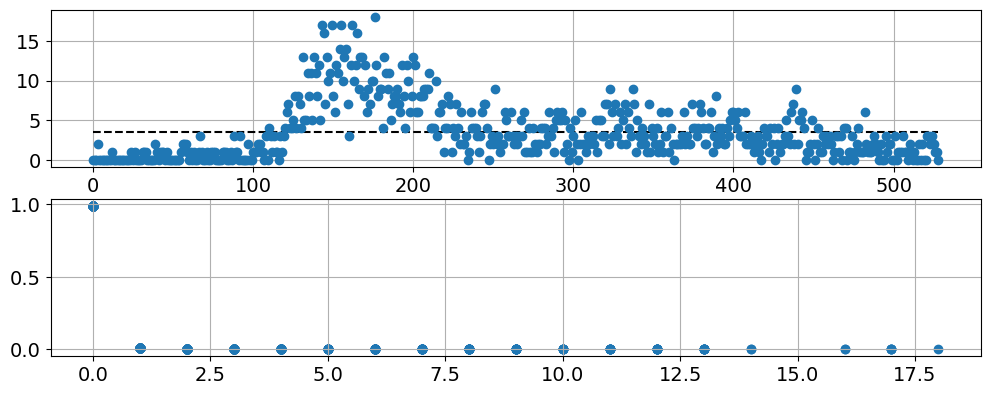

In [380]:
## Probability mass calculation 
step=500
num_of_turns=len(Lines)
print(num_of_turns)
windows=np.zeros(int(num_of_turns/step+(0<num_of_turns%step)))
extr=(particle_df.at_turn[np.where(particle_df.state == -2)])
print(extr)
windows[0]=sum((extr<step))
temp1=windows[0]
for i in range (1,len(windows)):
    temp2=sum((extr<i*step)*(extr<(i-1)*step))
    windows[i]=sum((extr<i*step)*(extr<(i-1)*step))-temp1
    temp1=temp2

from scipy.stats import poisson
y=poisson.pmf(windows,mu=setpoint,loc=0)

fig, [ax1,ax2] = plt.subplots(nrows=2, ncols=1,figsize=(12,9/2), sharex=0)
ax1.plot( step*realpoint*np.ones(len(windows)),'--k')
ax1.plot(windows,'o')
ax1.grid()

ax2.scatter(windows,y)
ax2.grid()

0.00715321667543936


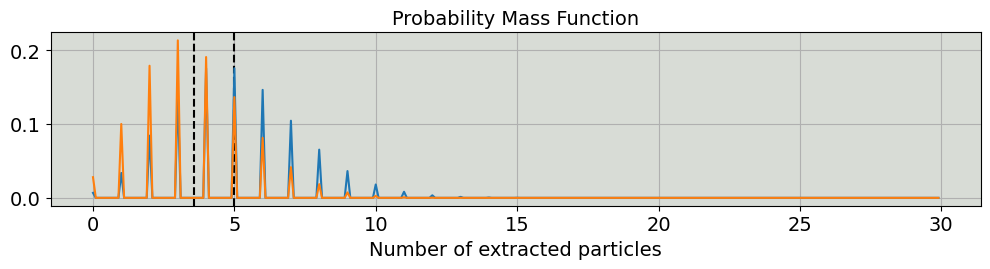

In [403]:
#importing poisson from scipy

from scipy.stats import poisson
 
step=500

#importing numpy as np

import numpy as np
 

#importing matplotlib as plt

import matplotlib.pyplot as plt
 
 

#creating a numpy array for x-axis

x = np.arange(0, 30, 0.1)
 

#poisson distribution data for y-axis

y_set = poisson.pmf(x, mu=step*setpoint, loc=0)
y_real = poisson.pmf(x, mu=step*realpoint, loc=0)
print(realpoint)

fig, ax= plt.subplots(nrows=1, ncols=1, figsize=(12, 9/4), sharex=True)
ax.axvline(x = step*setpoint, color = 'k', ls='--',label = 'axvline - full height')
ax.axvline(x = step*realpoint, color = 'k', ls='--',label = 'axvline - full height')
ax.plot(x,y_set)
ax.plot(x,y_real)
ax.set_facecolor('#d8dcd6')
ax.set_title("Probability Mass Function")
ax.set_xlabel("Number of extracted particles")
ax.grid()

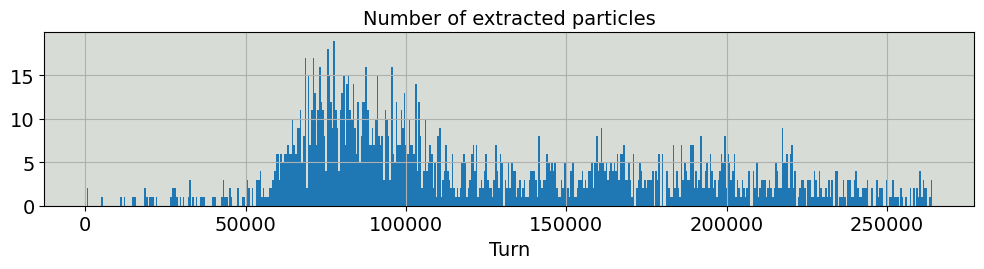

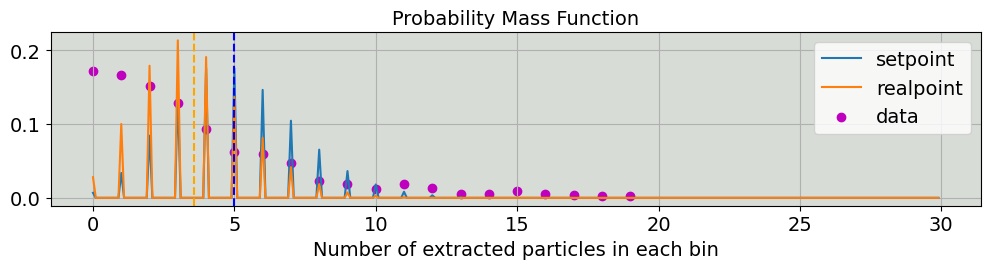

In [404]:
fig, ax1= plt.subplots(nrows=1, ncols=1, figsize=(12, 9/4), sharex=False)
a=particle_df.at_turn[np.where(particle_df.state == -2)]
h,_,_=ax1.hist(a, int(nturns/step))
ax1.set_facecolor('#d8dcd6')
ax1.set_xlabel("Turn")
ax1.set_title("Number of extracted particles")
ax1.grid()

#ext_particles=particle_df.at_turn[np.where(particle_df.state == -2)]
uni_num=np.unique(h)
count=np.zeros(len(uni_num))

#print(h,uni_num)
for i in range (0, len(uni_num)):
    count[i]=len(np.where(h==uni_num[i])[0])/len(h)
#print(np.where(h==uni_num[i])[0],count[i])

fig, ax2= plt.subplots(nrows=1, ncols=1, figsize=(12, 9/4), sharex=False)

ax2.plot(x,y_set)
ax2.plot(x,y_real)
ax2.set_facecolor('#d8dcd6')
ax2.set_title("Probability Mass Function")
ax2.set_xlabel("Number of extracted particles in each bin")
ax2.grid()
ax2.scatter(np.array(range(0,len(count))),count,color='m')
ax2.axvline(x = step*setpoint, color = 'blue', ls='--',label = 'axvline - full height')
ax2.axvline(x = step*realpoint, color = 'orange', ls='--',label = 'axvline - full height')

ax2.legend(['setpoint','realpoint','data'])


In [354]:
array=(particle_df.at_turn[np.where(particle_df.state == -2)])
print(array)


[264084 264078 263886 ...   5032    723    506]


[264084 264078 263886 ...   5032    723    506]
1770
[0. 0. 0. ... 0. 0. 0.]
0
[1. 1. 1. ... 1. 1. 1.]
1889.0
1887.0


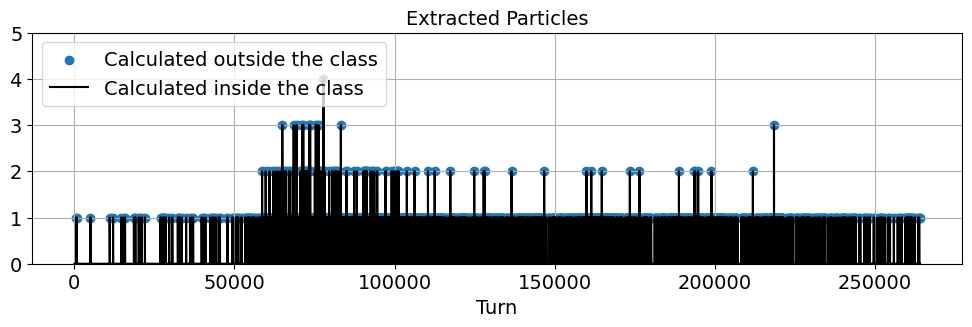

In [355]:
array=(particle_df.at_turn[np.where(particle_df.state == -2)])
print(array)

uniq=np.unique(array)
print(len(uniq))

H=np.zeros(( len(uniq)))
print(H)
print(len(np.where(array==11960)[0]))

for i in range(0, len(uniq)):
    H[i]=len((np.where(array==uniq[i])[0]))
print(H)


fig, ax = plt.subplots(figsize=(12,3))
ax.scatter(uniq,H)
ax.plot(turn,loss,'k')
ax.set_ylim(0,5)
ax.set_xlabel("Turn")
ax.set_title("Extracted Particles")

ax.legend(["Calculated outside the class", "Calculated inside the class"],loc="upper left")
ax.grid()
print(sum(H))
print(sum(loss))


extr 4.0 264077


Text(0.5, 0, 'Turns')

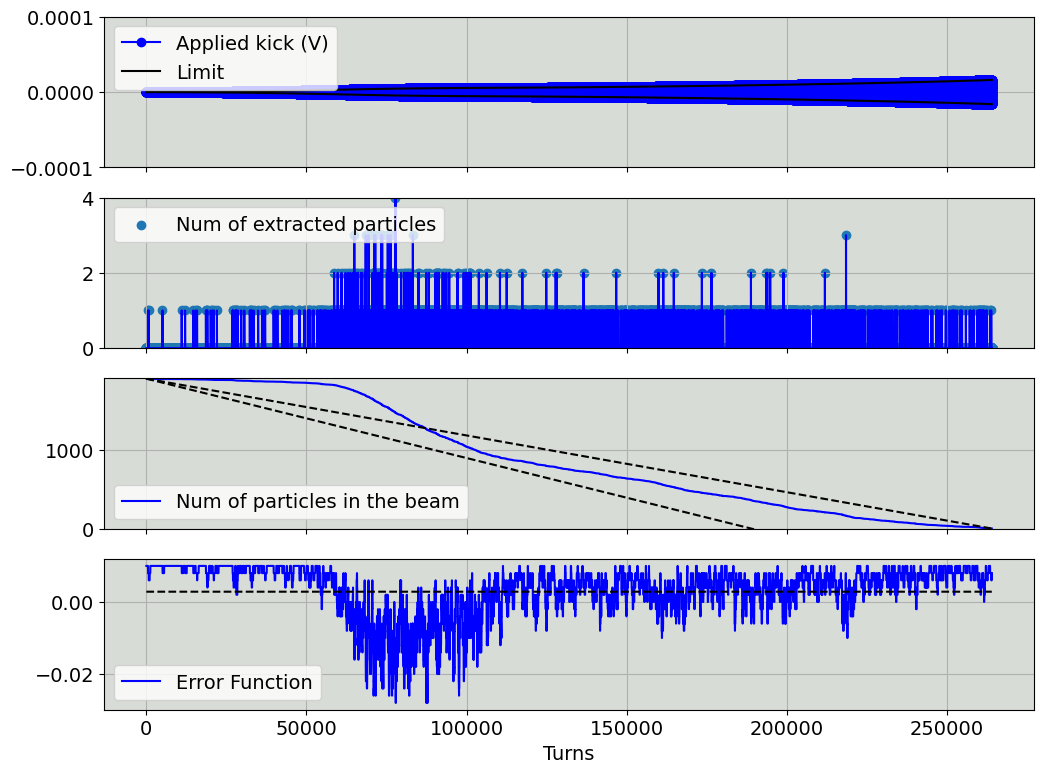

In [360]:
fig, [ax1,ax2,ax3, ax4] = plt.subplots(nrows=4, ncols=1, figsize=(12, 9), sharex=True)
## Applied kick
ax1.plot(turn, kick,'o-',color='b')
ax1.plot(turn, np.array(limit),color='k')
ax1.plot(turn,-np.array(limit),color='k')
ax1.set_facecolor('#d8dcd6')
ax1.set_ylim(-1E-4,1E-4)    

## Beam spill histogram
ax2.scatter(turn,loss)
ax2.plot(turn,loss,'b')
ax2.set_ylim([0,max(loss)])

## Number of particles in the beam
nparticles=len(particle_df.state)
limit_arr=np.array(limit)
time=np.array(range(0,int(nturns)))
realpoint=(nparticles-extr_particles_per_turn[-1])/len(turn)
print('extr',extr_particles_per_turn[-1],len(turn))
line1=nparticles-setpoint*np.array(turn)
line2=nparticles-realpoint*np.array(turn)
ax3.plot(turn,extr_particles_per_turn[0:len(turn)],'b')
ax3.plot(turn,line1,'--k')
ax3.plot(turn,line2,'--k')
ax3.set_ylim((min(extr_particles_per_turn)-5,max(extr_particles_per_turn)+5))

## Error function
ax4.plot(turn,error,'b')#,marker='.')
plt.plot(turn, (setpoint-realpoint)*np.ones(len(turn)),'--k')

Lim=nturns/6
name=["","Num of extracted particles","Num of particles in the beam","Error Function" ]
i=0
for ax in (ax1,ax2,ax3,ax4):    
#    ax.axvline(x = Lim , color = 'm')
    #ax.set_xlim(0,12000)
    ax.set_facecolor('#d8dcd6')
    ax.grid()
    # ax.set_xlim(0,200)
    i+=1
ax1.legend(["Applied kick (V)","Limit"],loc='upper left')
ax2.legend([name[1]],loc='upper left')
ax3.legend([name[2]],loc='lower left')
ax4.legend([name[3]],loc='lower left')
ax4.set_xlabel("Turns")
#ax1.set_xlim(10250,10300)


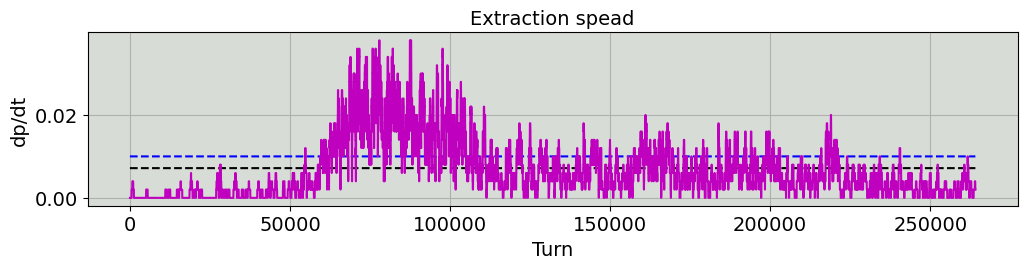

In [357]:
fig, ax= plt.subplots(nrows=1, ncols=1, figsize=(12, 9/4), sharex=True)
ax.plot(turn, setpoint*np.ones(len(turn)),'--b')
ax.plot(turn, realpoint*np.ones(len(turn)),'--k')
ax.plot(turn,dpdt,'m')
ax.set_title('Extraction spead')
ax.set_xlabel('Turn')
ax.set_ylabel('dp/dt')
ax.set_facecolor('#d8dcd6')
#ax.legend(["Setpoint frequency", "Real frequency"],loc="upper left")

ax.grid()


In [358]:
print(realpoint,setpoint,setpoint/realpoint)

0.007168363772687512 0.01 1.3950184891706285
